## Data Set Description :

### This dataset includes two files, Training and Testing, with a total of about 6,000 MRI images.. The images are categorized into the following levels of Alzheimer's disease levels:

#### **.** Mild Dementia
#### **.** Very Mild Dementia
#### **.** No Dementia
#### **.** Moderate Dementia

### A machine learning model will be used to predict the level of Alzheimer's disease based on MRI images.

## 1. Import important Library 📚

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dense, BatchNormalization , Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data 👓

In [ ]:
!apt install unzip

In [ ]:
!unzip  '../archive.zip' -d '../Untitled Folder'

In [ ]:
image_generator_train = ImageDataGenerator(
    rescale=1.0/255.0,
    #zoom_range=0.1,
    #shear_range=0.1,
    validation_split=0.2)


image_generator_test = ImageDataGenerator(
    rescale=1./255.)

In [ ]:
BATCH = 24
EPOCHS = 100

In [ ]:
train_data_dir = "../Alzheimer_s Dataset/train"
test_data_dir = "../Alzheimer_s Dataset/test"

In [ ]:
train_data = image_generator_train.flow_from_directory(
    train_data_dir,
    target_size=(176, 208),
    batch_size=BATCH,
    class_mode='categorical',
    subset='training')


validation_data = image_generator_train.flow_from_directory(
    train_data_dir,
    target_size=(176, 208),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation')



test_data = image_generator_test.flow_from_directory(
    test_data_dir,
    target_size=(176, 208),
    batch_size=BATCH,
    class_mode='categorical')


Found 4098 images belonging to 4 classes.

Found 1023 images belonging to 4 classes.

Found 1279 images belonging to 4 classes.


In [ ]:
train_data.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
len(train_data)

171

## 3. Visualization  

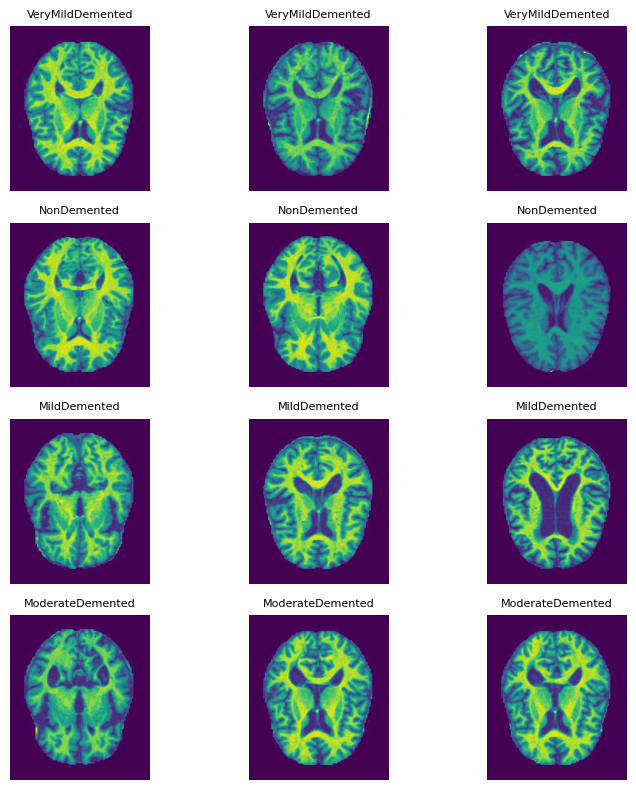

In [13]:
parent_folder = '../Alzheimer_s Dataset/train'
class_folders = [d for d in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, d))]

fig, axes = plt.subplots(4, 3, figsize=(8, 8))

images = []
labels = []
for class_folder in class_folders:
    class_path = os.path.join(parent_folder, class_folder)
    for img_name in os.listdir(class_path)[:3]:
        img_path = os.path.join(class_path, img_name)
        if os.path.isfile(img_path):
            images.append(Image.open(img_path))
            labels.append(class_folder)


images = images[:12]
labels = labels[:12]

for ax, img, label in zip(axes.flatten(), images, labels):
    ax.imshow(img)
    ax.set_title(label, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


## 4. Model

In [ ]:
from keras import backend as K
K.image_data_format()

'channels_last'

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(176, 208, 3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=  l2(0.00001)))

model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_6 (Conv2D)           (None, 174, 206, 32)      896       

                                                                 

 batch_normalization_10 (Ba  (None, 174, 206, 32)      128       

 tchNormalization)                                               

                                                                 

 dropout_10 (Dropout)        (None, 174, 206, 32)      0         

                                                                 

 conv2d_7 (Conv2D)           (None, 172, 204, 32)      9248      

                                                                 

 batch_normalization_11 (Ba  (None, 172, 204, 32)      128       

 tchNormalization)                                               

                                                                 

 average_pooling2d_4 (Avera  (None, 86

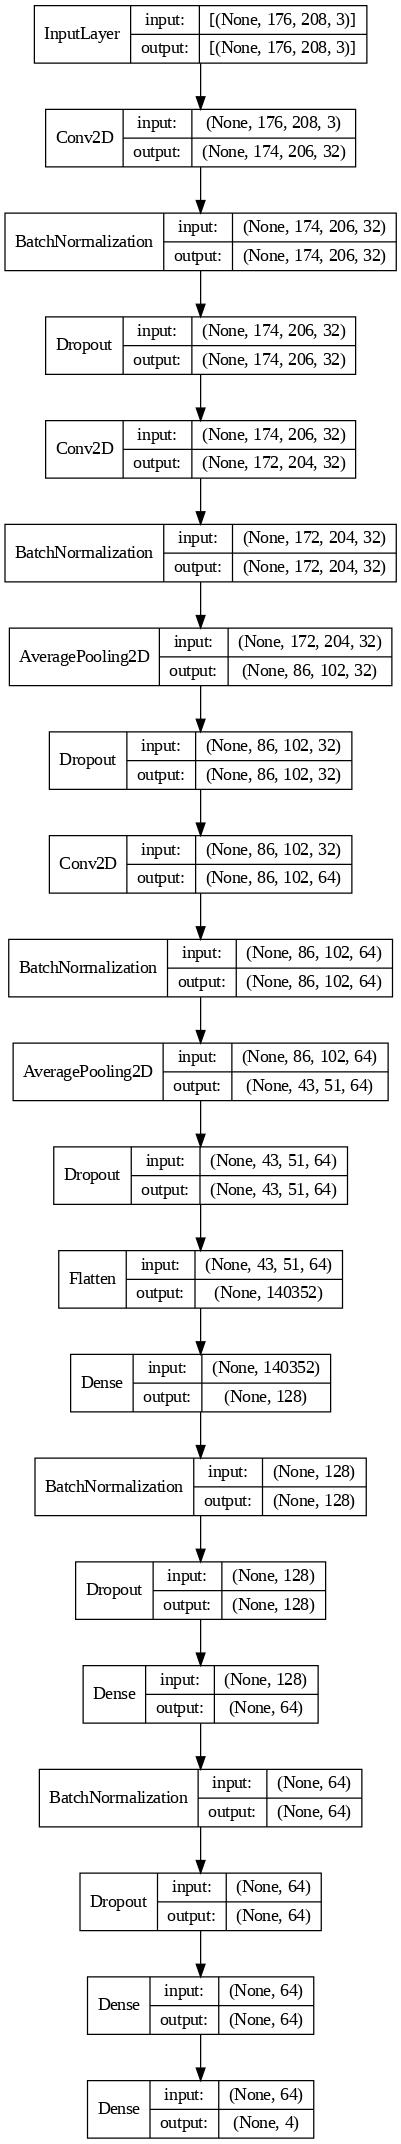

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=False,dpi=90)

In [ ]:
optimizer = Adam(learning_rate=0.01)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)

array([ 1.78484321, 24.39285714,  0.50024414,  0.71443515])

In [ ]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)

In [ ]:
class_weights = dict(zip(np.unique(train_data.classes), weights))

In [ ]:
class_weights

{0: 1.7848432055749128,
 1: 24.392857142857142,
 2: 0.500244140625,
 3: 0.7144351464435147}

In [ ]:
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.1,  min_lr=0.00000001)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights= True )

In [ ]:
len(validation_data)

43

In [ ]:
history = model.fit(train_data, steps_per_epoch=len(train_data), callbacks=[rlrop,es], epochs=100, validation_data=validation_data, validation_steps=len(validation_data), class_weight=class_weights)

Epoch 1/100

171/171 [==============================] - 24s 110ms/step - loss: 2.0637 - accuracy: 0.3870 - val_loss: 6.0415 - val_accuracy: 0.2493 - lr: 0.0100

Epoch 2/100

171/171 [==============================] - 19s 110ms/step - loss: 1.8415 - accuracy: 0.4636 - val_loss: 2.8370 - val_accuracy: 0.5015 - lr: 0.0100

Epoch 3/100

171/171 [==============================] - 18s 106ms/step - loss: 1.7316 - accuracy: 0.5090 - val_loss: 9.6198 - val_accuracy: 0.5024 - lr: 0.0100

Epoch 4/100

171/171 [==============================] - 19s 109ms/step - loss: 1.5217 - accuracy: 0.5686 - val_loss: 2.2313 - val_accuracy: 0.2923 - lr: 0.0100

Epoch 5/100

171/171 [==============================] - 18s 106ms/step - loss: 1.4347 - accuracy: 0.6091 - val_loss: 2.3651 - val_accuracy: 0.4457 - lr: 0.0100

Epoch 6/100

171/171 [==============================] - 19s 108ms/step - loss: 1.4789 - accuracy: 0.6293 - val_loss: 2.1725 - val_accuracy: 0.5543 - lr: 0.0100

Epoch 7/100

171/171 [============

## 5. Model Metrics Visualization

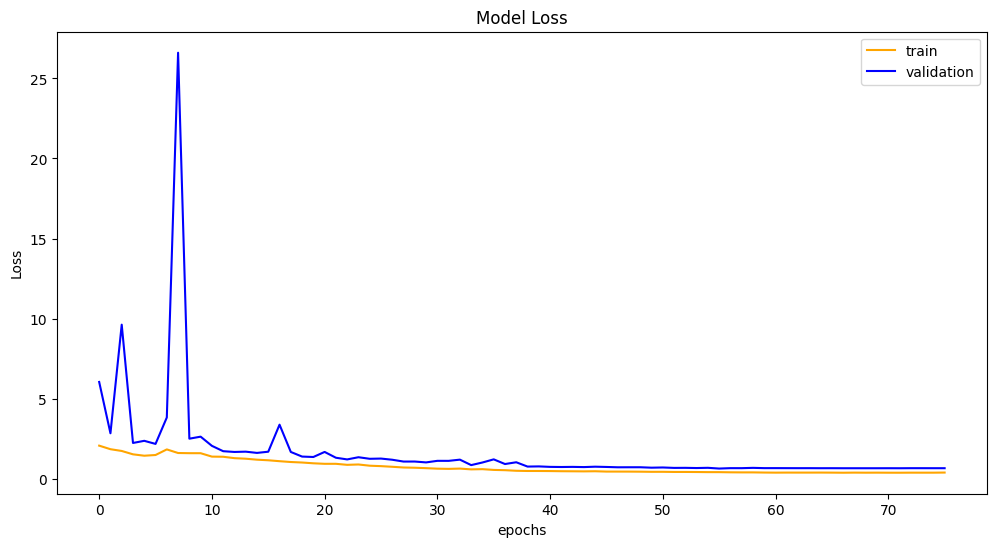

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'],c='orange')
plt.plot(history.history['val_loss'],c='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['train','validation'])
plt.show()

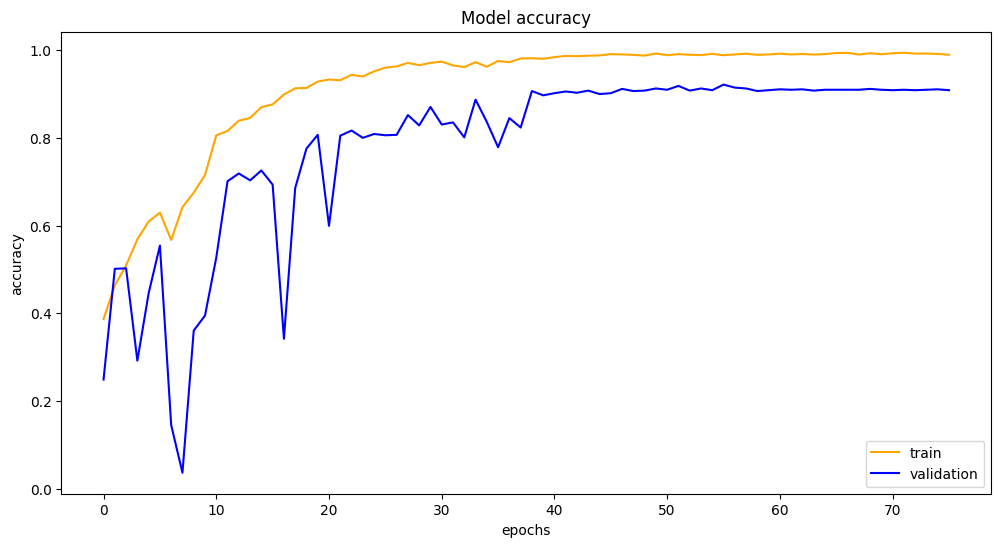

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'],c='orange')
plt.plot(history.history['val_accuracy'],c='b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='lower right')
plt.show()

## 6. Model Evaluation with test data

In [ ]:
model.evaluate(test_data)

54/54 [==============================] - 2s 30ms/step - loss: 1.8590 - accuracy: 0.6740


[1.8590118885040283, 0.6739640235900879]